In [84]:
from io import open
import unicodedata
import string
import re
import random
import os
import numpy as np

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device="cpu"
print(device)

cuda


In [2]:
class Lang:
    def __init__(self, name = 'news'):
        self.name = name
        self.word2index = {"NNNN": 0}
        self.word2count = {"NNNN": 0}
        self.index2word = {0: "NNNN"}
        self.n_words = 1  #NNNN

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [3]:
MIN_LEN = 5
MAX_LEN = 30

def filterSeq(s):
    return len(s.split(' ')) < MAX_LEN and len(s.split(' ')) > MIN_LEN

def standardizeSeq(s):
    return s + " NNNN" * (MAX_LEN - len(s.split(' ')))

def filterS(ss):
    return [standardizeSeq(s) for s in ss if filterSeq(s)]

In [4]:
def readLangs(name):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('%s.txt' % (name)).read().strip().split('\n')
    
    lines = [(' ').join(s) for s in lines]
    # Split every line into pairs and normalize
    #pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    return lines

In [5]:
def prepareData():
    fm_lang = readLangs('fmxw1')
    zm_lang = readLangs('zmxw1')
    print("Read %s sentence" % (len(zm_lang)+len(fm_lang)))
    zm_lang = filterS(zm_lang)
    fm_lang = filterS(fm_lang)
    print("Trimmed to %s sentence pairs" % (len(zm_lang)+len(fm_lang)))
    print("Counting words...")
    lang = Lang()
    pairs = []
    for s in zm_lang:
        lang.addSentence(s)
        pairs.append((s,1))
    for s in fm_lang:
        lang.addSentence(s)
        pairs.append((s,0))
    print("Counted words:")
    print(lang.n_words)
    return lang, pairs

lang, pairs = prepareData()
random.shuffle(pairs)
print(random.choice(pairs))

Reading lines...
Reading lines...
Read 12597 sentence
Trimmed to 11925 sentence pairs
Counting words...
Counted words:
2259
('新 凤 鸣 拟 万 美 元 设 立 中 益 化 纤 NNNN NNNN NNNN NNNN NNNN NNNN NNNN NNNN NNNN NNNN NNNN NNNN NNNN NNNN NNNN NNNN NNNN', 1)


In [6]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1)#这里把它变成了一个向量

def tensorsFromPairs(pairs):
    input_list = [indexesFromSentence(lang,pair[0]) for pair in pairs]
    input_tensor = torch.tensor(input_list, dtype=torch.long, device=device)
    label_list = [pair[1] for pair in pairs]
    label_tensor = torch.tensor(label_list, dtype=torch.long, device=device)
    return input_tensor, label_tensor

In [7]:
class PositionEncoding(nn.Module):
    def __init__(self, max_len, word_size):
        super(PositionEncoding, self).__init__()
        self.position_mat = torch.tensor([[pos/np.power(10000,i//2*2/word_size) for i in range(word_size)] for pos in range(max_len)], \
                                        dtype = torch.float32).to(device)
        self.position_mat[:,0::2] = torch.sin(self.position_mat[:,0::2])
        self.position_mat[:,1::2] = torch.cos(self.position_mat[:,1::2])
    
    def forward(self, input):
        return input + self.position_mat[0:input.size(-2),0:input.size(-1)]

In [22]:
class Newsmodel(nn.Module):
    def __init__(self, word_size, embed_size, ff_dim = 512, num_layers = 3, nhead = 2, max_len = MAX_LEN):
        super(Newsmodel, self).__init__()
        
        self.word_size = word_size
        self.embed_size = embed_size 
        self.ff_dim = ff_dim
        self.num_layers = num_layers
        self.nhead = nhead
        self.max_len = max_len
        
        self.embedding = nn.Embedding(word_size, embed_size, padding_idx = 0)
        self.position_encoding = PositionEncoding(max_len, embed_size)
        self.transformer_encoder = nn.TransformerEncoder( nn.TransformerEncoderLayer(embed_size, nhead, dim_feedforward=ff_dim) , num_layers)
        #self.out_linear = nn.Linear(embed_size *  max_len, 2)
        self.out_linear = nn.Linear(embed_size,2)
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, input):
        X = self.position_encoding(self.embedding(input)) #batch * max_len * embed_size
        X = self.transformer_encoder(X) #batch * max_len * embed_size
        #output = self.out_linear(X.view(-1, self.embed_size * self.max_len))
        output = self.out_linear(X.sum(dim=1))
        return F.log_softmax(self.dropout(output),dim=-1)

In [23]:
model1 = Newsmodel(5, 4, 32).to(device)
input1 = torch.tensor([[1]*30], dtype = torch.long, device = device)
print(model1(input1))

tensor([[-22.4909,   0.0000]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)


In [24]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m,s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [25]:
def train(model, input_tensor, target_tensor, optimizer, criterion):

    #清空梯度
    optimizer.zero_grad()
    
    target_length = target_tensor.size(0)
    
    
    outputs = model(input_tensor)
    
    loss = criterion(outputs, target_tensor)
    
    loss.backward()
    
    optimizer.step()
    
    return loss.item()*100

In [26]:
#这里才是总的训练
def trainIters(model, pairs, n_iters, batch_size = 100, print_every=1000, plot_every=100, learning_rate=0.0001):
    model.train()
    assert n_iters % batch_size == 0
    assert print_every % batch_size == 0
    assert plot_every % batch_size == 0
    start = time.time()
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0
    
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    train_input, train_label = tensorsFromPairs([random.choice(pairs) for i in range(n_iters)])
    criterion = nn.NLLLoss()
    
    for iter in range(batch_size, n_iters+1, batch_size):
        input_tensor = train_input[iter - batch_size : iter-1]
        target_tensor = train_label[iter - batch_size : iter-1]
        
        loss = train(model, input_tensor, target_tensor, optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss
        
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters), iter, iter / n_iters * 100, print_loss_avg))
        
        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    
    showPlot(plot_losses)

In [80]:
def sentenceFromIndexes(sentence):
    return [lang.index2word[word] for word in sentence if word is not 0]

def predict(model, pairs):
    model.eval()
    train_input, train_label = tensorsFromPairs([random.choice(pairs) for i in range(100)])
    #train_input, train_label = tensorsFromPairs(pairs)
    _,outputs = model(train_input).max(dim = 1)
    correct = float(outputs.eq(train_label).sum().item())
    for i in range(10):
        input_a = train_input[i].to('cpu').detach().numpy().tolist()
        print(">>>",''.join(sentenceFromIndexes(input_a)),outputs[i].to('cpu').detach().numpy(),train_label[i].to('cpu').detach().numpy())
    print(correct)
    return correct

In [28]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

cuda
0m 6s (- 2m 9s) (10000 5%) 2.8570
0m 12s (- 1m 53s) (20000 10%) 0.6878
0m 18s (- 1m 43s) (30000 15%) 0.5680
0m 23s (- 1m 35s) (40000 20%) 0.5406
0m 29s (- 1m 28s) (50000 25%) 0.4321
0m 35s (- 1m 22s) (60000 30%) 0.4214
0m 41s (- 1m 16s) (70000 35%) 0.4305
0m 46s (- 1m 10s) (80000 40%) 0.3900
0m 52s (- 1m 4s) (90000 45%) 0.3816
0m 58s (- 0m 58s) (100000 50%) 0.3628
1m 4s (- 0m 52s) (110000 55%) 0.3756
1m 10s (- 0m 46s) (120000 60%) 0.3483
1m 16s (- 0m 40s) (130000 65%) 0.3605
1m 21s (- 0m 35s) (140000 70%) 0.3215
1m 27s (- 0m 29s) (150000 75%) 0.3135
1m 33s (- 0m 23s) (160000 80%) 0.3153
1m 39s (- 0m 17s) (170000 85%) 0.3374
1m 45s (- 0m 11s) (180000 90%) 0.3009
1m 51s (- 0m 5s) (190000 95%) 0.3236
1m 57s (- 0m 0s) (200000 100%) 0.3059


<Figure size 432x288 with 0 Axes>

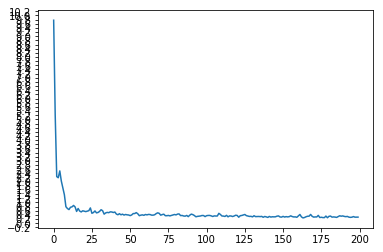

In [29]:
print(device)
model = Newsmodel(lang.n_words, 256, num_layers = 6).to(device)

trainIters(model, pairs[0:-1000], 200000, print_every=10000, plot_every=1000)

0m 6s (- 2m 12s) (10000 5%) 0.2971
0m 12s (- 1m 55s) (20000 10%) 0.2881
0m 18s (- 1m 45s) (30000 15%) 0.2884
0m 24s (- 1m 37s) (40000 20%) 0.2903
0m 30s (- 1m 30s) (50000 25%) 0.2931
0m 36s (- 1m 24s) (60000 30%) 0.2733
0m 42s (- 1m 18s) (70000 35%) 0.2779
0m 47s (- 1m 11s) (80000 40%) 0.2670
0m 53s (- 1m 5s) (90000 45%) 0.2778
0m 59s (- 0m 59s) (100000 50%) 0.2762
1m 5s (- 0m 53s) (110000 55%) 0.2696
1m 11s (- 0m 47s) (120000 60%) 0.2590
1m 17s (- 0m 41s) (130000 65%) 0.2731
1m 23s (- 0m 35s) (140000 70%) 0.2604
1m 29s (- 0m 29s) (150000 75%) 0.2702
1m 34s (- 0m 23s) (160000 80%) 0.2776
1m 40s (- 0m 17s) (170000 85%) 0.2661
1m 46s (- 0m 11s) (180000 90%) 0.2673
1m 52s (- 0m 5s) (190000 95%) 0.2584
1m 57s (- 0m 0s) (200000 100%) 0.2576


<Figure size 432x288 with 0 Axes>

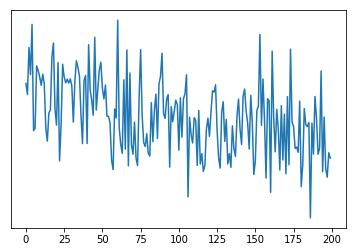

In [32]:
trainIters(model, pairs[0:-1000], 200000, print_every=10000, plot_every=1000, learning_rate=0.00005)

0m 6s (- 2m 12s) (10000 5%) 0.2533
0m 12s (- 1m 55s) (20000 10%) 0.2584
0m 18s (- 1m 45s) (30000 15%) 0.2511
0m 24s (- 1m 37s) (40000 20%) 0.2552
0m 30s (- 1m 30s) (50000 25%) 0.2492
0m 35s (- 1m 23s) (60000 30%) 0.2501
0m 41s (- 1m 16s) (70000 35%) 0.2466
0m 47s (- 1m 10s) (80000 40%) 0.2599
0m 52s (- 1m 4s) (90000 45%) 0.2516
0m 58s (- 0m 58s) (100000 50%) 0.2566
1m 4s (- 0m 52s) (110000 55%) 0.2463
1m 10s (- 0m 46s) (120000 60%) 0.2590
1m 15s (- 0m 40s) (130000 65%) 0.2556
1m 21s (- 0m 34s) (140000 70%) 0.2566
1m 27s (- 0m 29s) (150000 75%) 0.2535
1m 32s (- 0m 23s) (160000 80%) 0.2340
1m 38s (- 0m 17s) (170000 85%) 0.2482
1m 44s (- 0m 11s) (180000 90%) 0.2462
1m 50s (- 0m 5s) (190000 95%) 0.2479
1m 55s (- 0m 0s) (200000 100%) 0.2396


<Figure size 432x288 with 0 Axes>

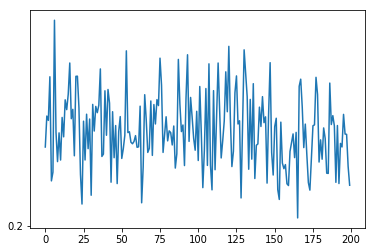

In [33]:
trainIters(model, pairs[0:-1000], 200000, print_every=10000, plot_every=1000, learning_rate=0.00002)

In [81]:
predict(model,pairs[-1000:])

>>> 江山欧派拟万元参设股权投资基金基金规模不超亿元 1 1
>>> 春风动力股东拟减持不超股份 0 0
>>> 博实股份控股股东计划转让不超过公司的股份 0 1
>>> 启迪桑德中标宜昌和监利共个项目 1 1
>>> 龙建股份中标亿元项目 1 1
>>> 宏达新材将现金收购上海观峰信息科技有限公司股权 1 1
>>> 大唐发电股东拟减持不超股份 0 0
>>> 海利生物两股东计划清仓式减持 0 0
>>> 大连电瓷子公司预中标万元合同 1 1
>>> 三安光电非公开发行股股票申请获得中国证监会审核通过 1 1
93.0


93.0

保存模型的方法就是调用`torch.save(model.state_dict(),'./modelpth')`其中，model是目前训练出来的模型的名字，modelpth是文件名，无需后缀名的，载入的时候首先实例化一个模型，然后`model.load_state_dict(torch.load('modelpth'))`就可以了，其中model是新实例化的模型的名称，这种方式是把模型的参数保存下来，然后到时候再把参数载入回去。

In [91]:
torch.save(model.state_dict(), './modelpth')

In [88]:
model1 = Newsmodel(lang.n_words, 256, num_layers = 6).to(device)

In [92]:
model1.load_state_dict(torch.load('modelpth'))

<All keys matched successfully>

In [90]:
predict(model1,pairs[-1000:])

>>> 鲁信创投子公司参股企业山东国信已过港交所聆讯 1 1
>>> 瑞特股份拟万元参设合资公司研发电源系统等 1 1
>>> 盛通股份拟回购万元亿元股份 1 1
>>> 华贸物流拟择机出售万股贵阳银行 1 1
>>> 渝农商行重庆小米消费金融公司开业 1 1
>>> 鸿特科技公告公司实控人将变更 1 1
>>> 长信科技上半年业绩预增 1 1
>>> 中水渔业收到政府补助万元 1 1
>>> 南京证券发行不超过亿元公司债获证监会核准 1 1
>>> 哈工智能拟收购易科机器人股权 1 1
96.0


96.0